In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from typing import Counter
from sklearn.model_selection import GridSearchCV

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
train["DeviceType"].value_counts()

desktop    63885
mobile     41516
Name: DeviceType, dtype: int64

Combine train and test data for Data Cleaning

In [4]:
main_df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

In [5]:
main_df.shape

(590540, 435)

In [6]:
main_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,isFraud
0,3460689,12245831,325.000,W,12932,361.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,NaN
1,3415050,10807203,37.257,C,14276,177.0,185.0,mastercard,137.0,credit,...,NaN,NaN,F,F,T,F,mobile,SM-G9600 Build/R16NW,test,NaN
2,3408682,10685267,100.000,R,16506,554.0,150.0,visa,226.0,credit,...,1536x960,match_status:2,T,F,T,F,desktop,Windows,test,NaN
3,3389297,10160809,57.950,W,9500,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,NaN
4,3366334,9492365,34.258,C,15885,545.0,185.0,visa,138.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,NaN


In [7]:
main_df.shape

(590540, 435)

In [8]:
main_df.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id_38             449555
DeviceType        449730
DeviceInfo        471874
ind                    0
isFraud           147635
Length: 435, dtype: int64

### Function to find correlated features

In [9]:
def corr_features(correlation_matrix, thres):
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > thres:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    print("Following are highly correlated features:", correlated_features)

# EDA

## Outlier detection

C:\Users\Prem Shah\AppData\Local\Temp\ipykernel_10004\2911233049.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['TransactionAmt'])


<AxesSubplot: xlabel='TransactionAmt', ylabel='Density'>

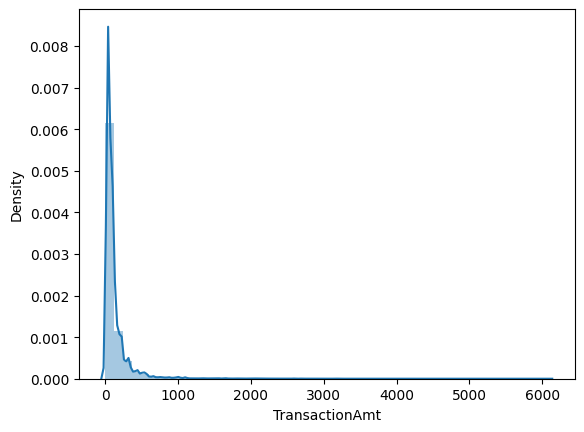

In [10]:
sns.distplot(train['TransactionAmt'])

<AxesSubplot: >

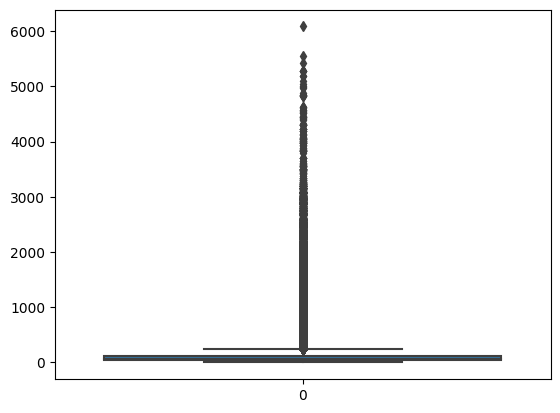

In [11]:
sns.boxplot(train['TransactionAmt'])

## Basic Information

In [12]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,4.429050e+05,442905.000000,4.429050e+05,442905.000000,442905.000000,436201.000000,441724.000000,439730.000000,393811.000000,393811.000000,...,104324.000000,33788.000000,104289.000000,104244.000000,3865.000000,3870.000000,3552.000000,3842.000000,3865.000000,58109.000000
mean,3.282059e+06,0.034989,7.366857e+06,135.273690,9901.266082,362.542367,153.188550,199.276736,290.654596,86.799658,...,189.429604,14.233278,353.493475,403.862774,370.234670,16.025581,12.851351,328.556221,149.187581,26.498202
std,1.705119e+05,0.183753,4.617568e+06,232.955213,4901.960786,157.784513,11.314301,41.232396,101.745146,2.684822,...,30.360205,1.561150,141.183369,152.298443,198.839627,6.947584,2.417639,97.420034,32.180887,3.733750
min,2.987002e+06,0.000000,8.646900e+04,0.251000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134224e+06,0.000000,3.021834e+06,43.744000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282155e+06,0.000000,7.301614e+06,68.950000,9680.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429574e+06,0.000000,1.123641e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,500.000000,14.000000,15.000000,367.750000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,6085.230000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,660.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


## Graphs

#### Transaction Amount

<AxesSubplot: xlabel='isFraud', ylabel='TransactionAmt'>

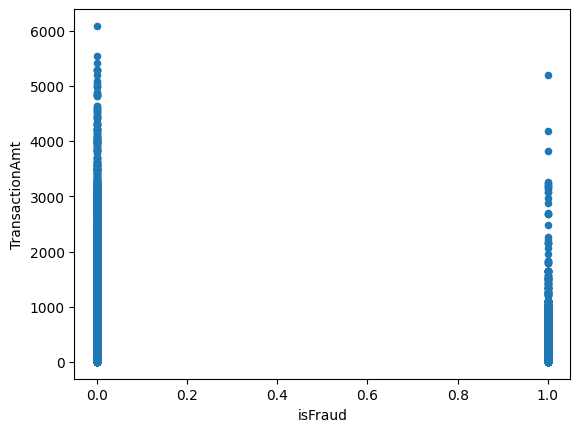

In [13]:
train.plot(x='isFraud', y='TransactionAmt', kind='scatter')

The training data shows that maximun frauds happen upto transaction amount of 4000. There are less chances of fraud at higher amount but still it can happen at any amount, yet we can infer that the transactions of more than 4000 could be genuine but not with 100% surety !!

#### Billing address

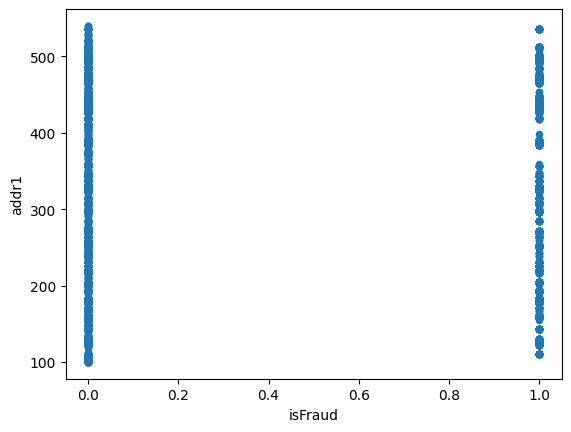

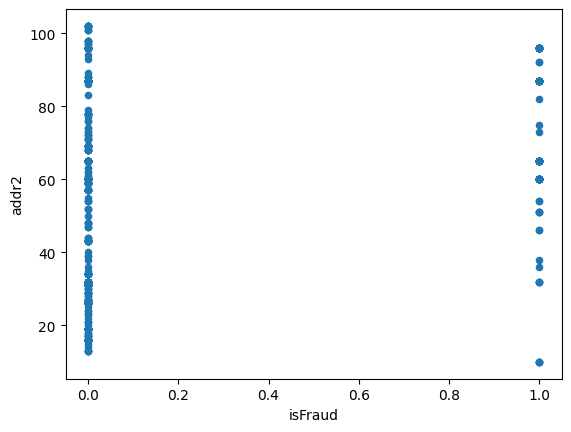

In [14]:
train.plot(x='isFraud', y='addr1', kind='scatter')
train.plot(x='isFraud', y='addr2', kind='scatter')
plt.show()

We can not say much about the transaction by just looking at the billing region (addr1) or billing country (addr2) as frauds are scattered all over the regions

#### Device Type

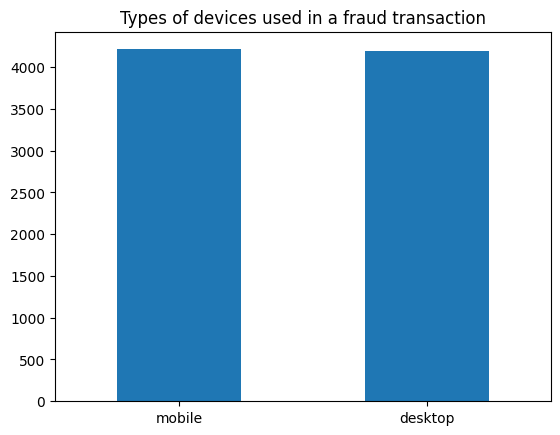

In [15]:
train.loc[train['isFraud'] == 1]["DeviceType"].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Types of devices used in a fraud transaction")
plt.show()

We can clearly see that the device type does not say anything about the transaction. One can fraud from desktop as well as mobile. So this feature is not of much use.

#### Transaction ID

In [16]:
print("Total data:", train.shape[0])
print("No. of unique values of transaction ID:", train["TransactionID"].nunique())

Total data: 442905
No. of unique values of transaction ID: 442905


As we can clearly see that there is a different Transaction ID for each transaction, this feature does not make much sense. We can remove this feature.

#### TransactionDT

“TransactionDT "corresponds to the number of seconds in a day.

This indicates a time delta from a given reference date and time

It is clearly a time-related information like how many days since transaction, etc. Adding this to the model won't make much sense. 

#### Product CD

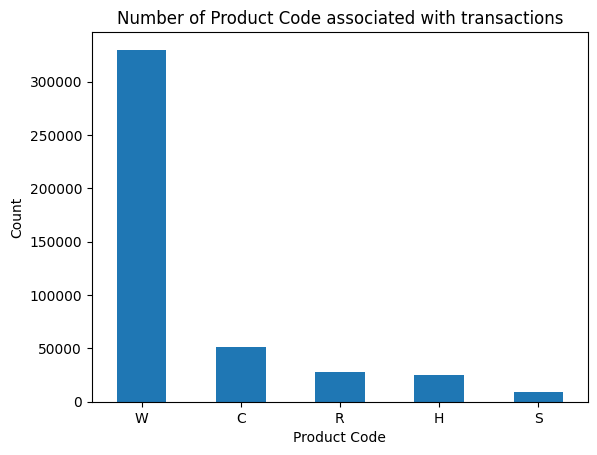

In [17]:
train["ProductCD"].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Number of Product Code associated with transactions")
plt.xlabel("Product Code")
plt.ylabel("Count")
plt.show()

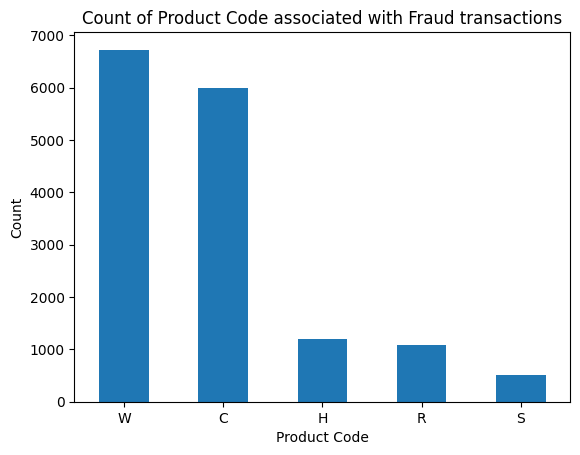

In [18]:
train.loc[train['isFraud'] == 1]["ProductCD"].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Count of Product Code associated with Fraud transactions")
plt.xlabel("Product Code")
plt.ylabel("Count")
plt.show()

Although we can see that products with ProductCD = 'W' have the most number of frauds, this is clear that out of number of products with code 'C' it has maximum percentage of fraud transactions.

There are about 50,000 products with code 'C' and about 6000 of them are fraud which makes it around 12%

And the other codes roughly makes it around 5-6%

#### Card

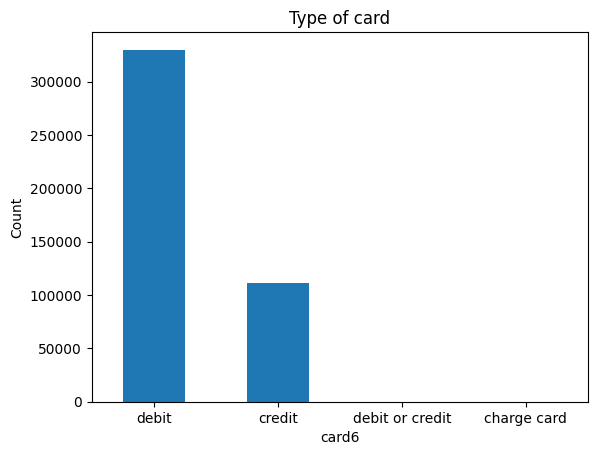

In [19]:
train["card6"].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Type of card")
plt.xlabel("card6")
plt.ylabel("Count")
plt.show()

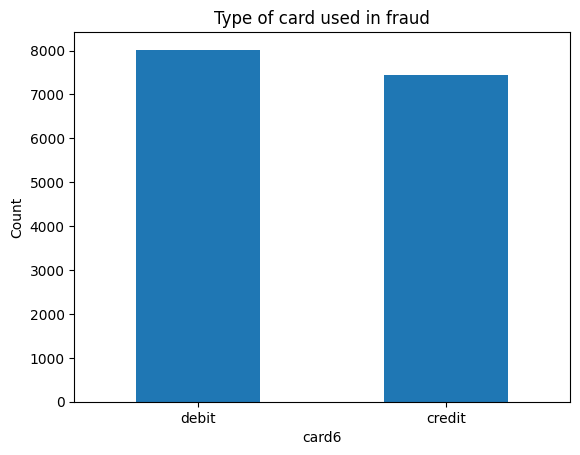

In [20]:
train.loc[train['isFraud'] == 1]["card6"].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Type of card used in fraud")
plt.xlabel("card6")
plt.ylabel("Count")
plt.show()

If you look at the overall data then credit card is used verly less in compare to debit card, but when it comes to fraud credit card are used almost same as debit card.

So we can conclude that there are bigger chance of transaction being fraud when credit card is used (7%) than debit card (2.5%).

#### M Columns

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
train[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']] = train[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']].apply(LabelEncoder().fit_transform)

In [23]:
M_features = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'isFraud']
corr_M = train[M_features].corr()

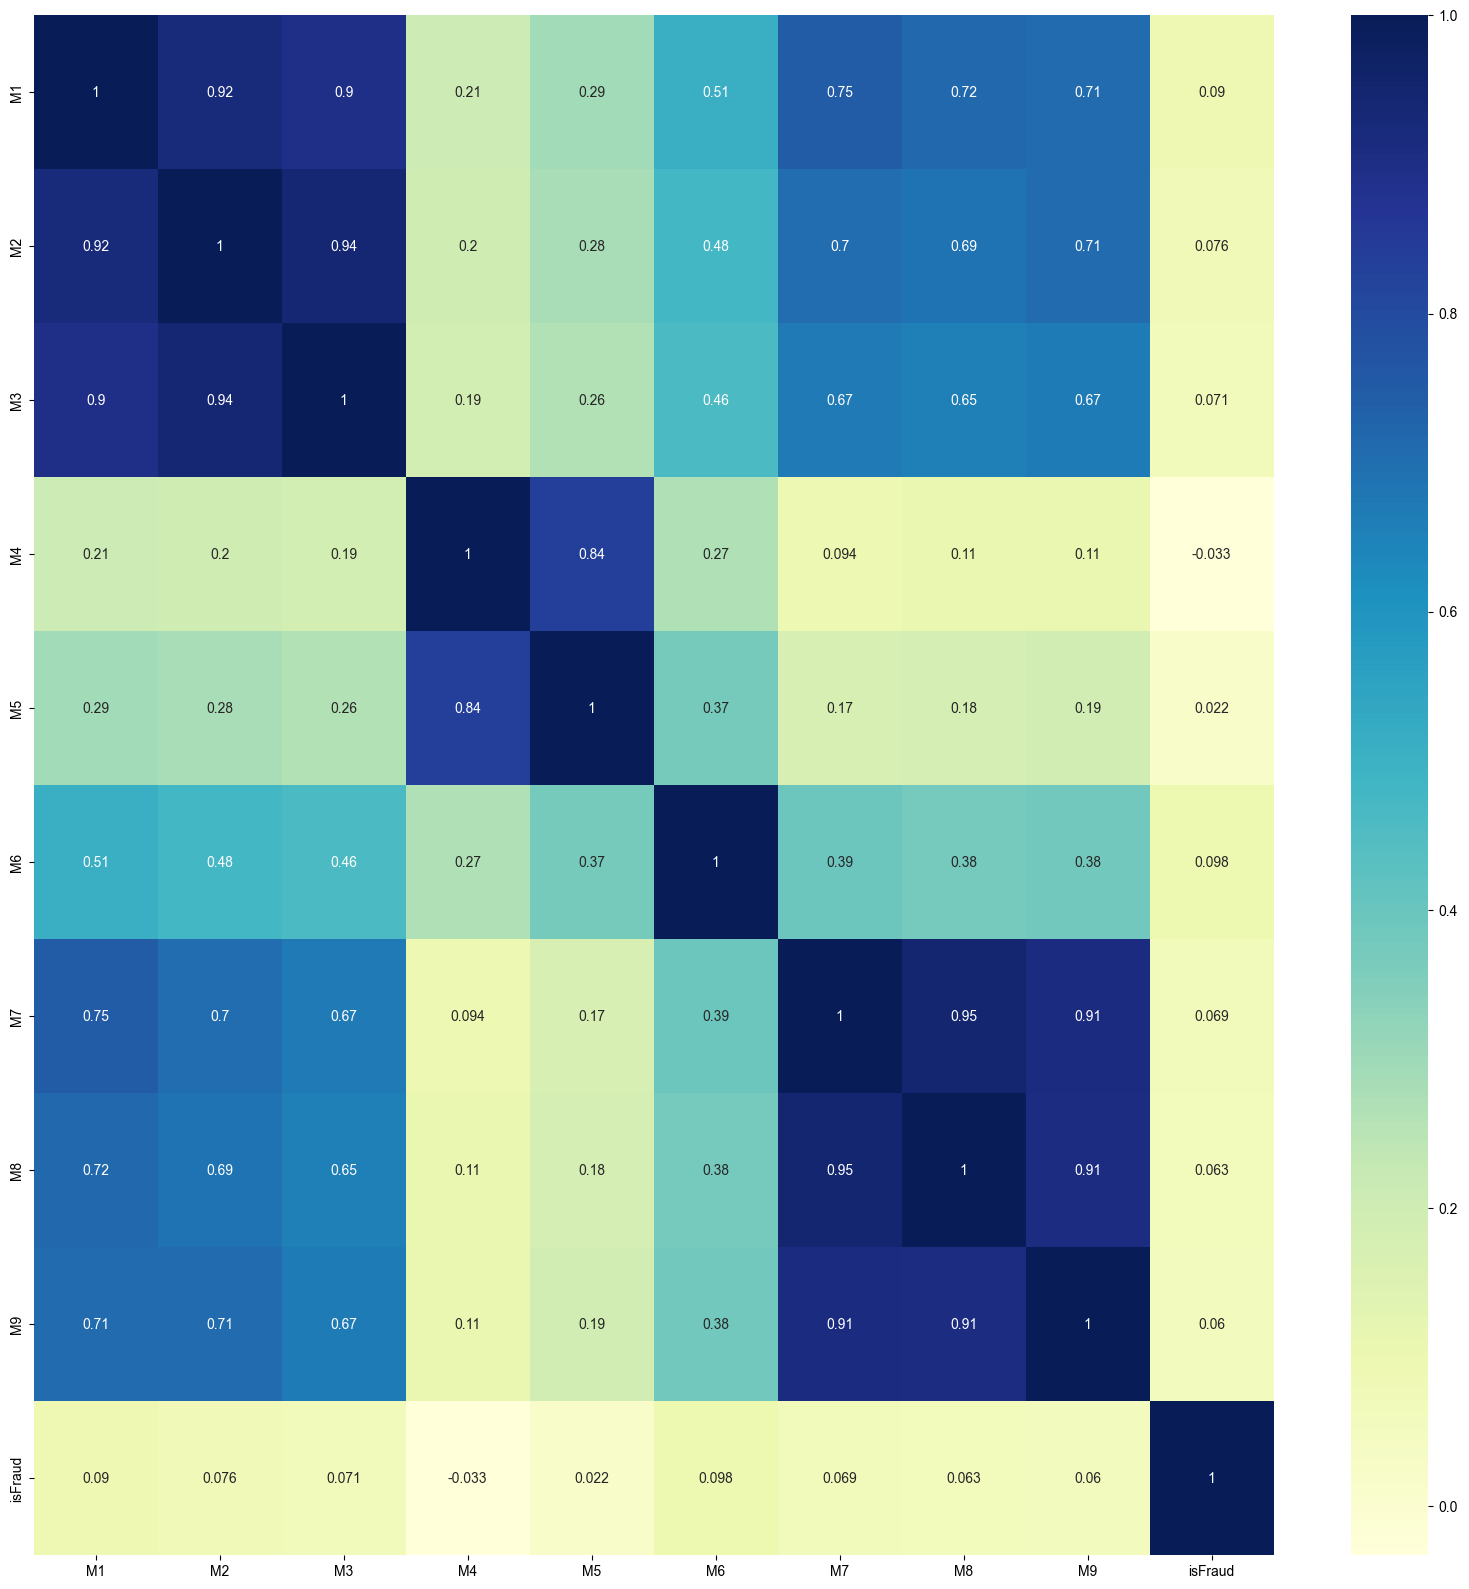

In [24]:
plt.subplots(figsize = (20, 20))
sns.heatmap(corr_M,annot=True, cmap = 'YlGnBu') 
sns.set(font_scale=1)

In [25]:
corr_features(corr_M, 0.9)

Following are highly correlated features: {'M2', 'M8', 'M9', 'M3'}


Here M2, M3, M8 and M9 are highly correlated

So we can keep only one of them and remove the others.

M2 is most correlated with isFraud among the four

#### D Columns

In [26]:
D_features = [ 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15'] 

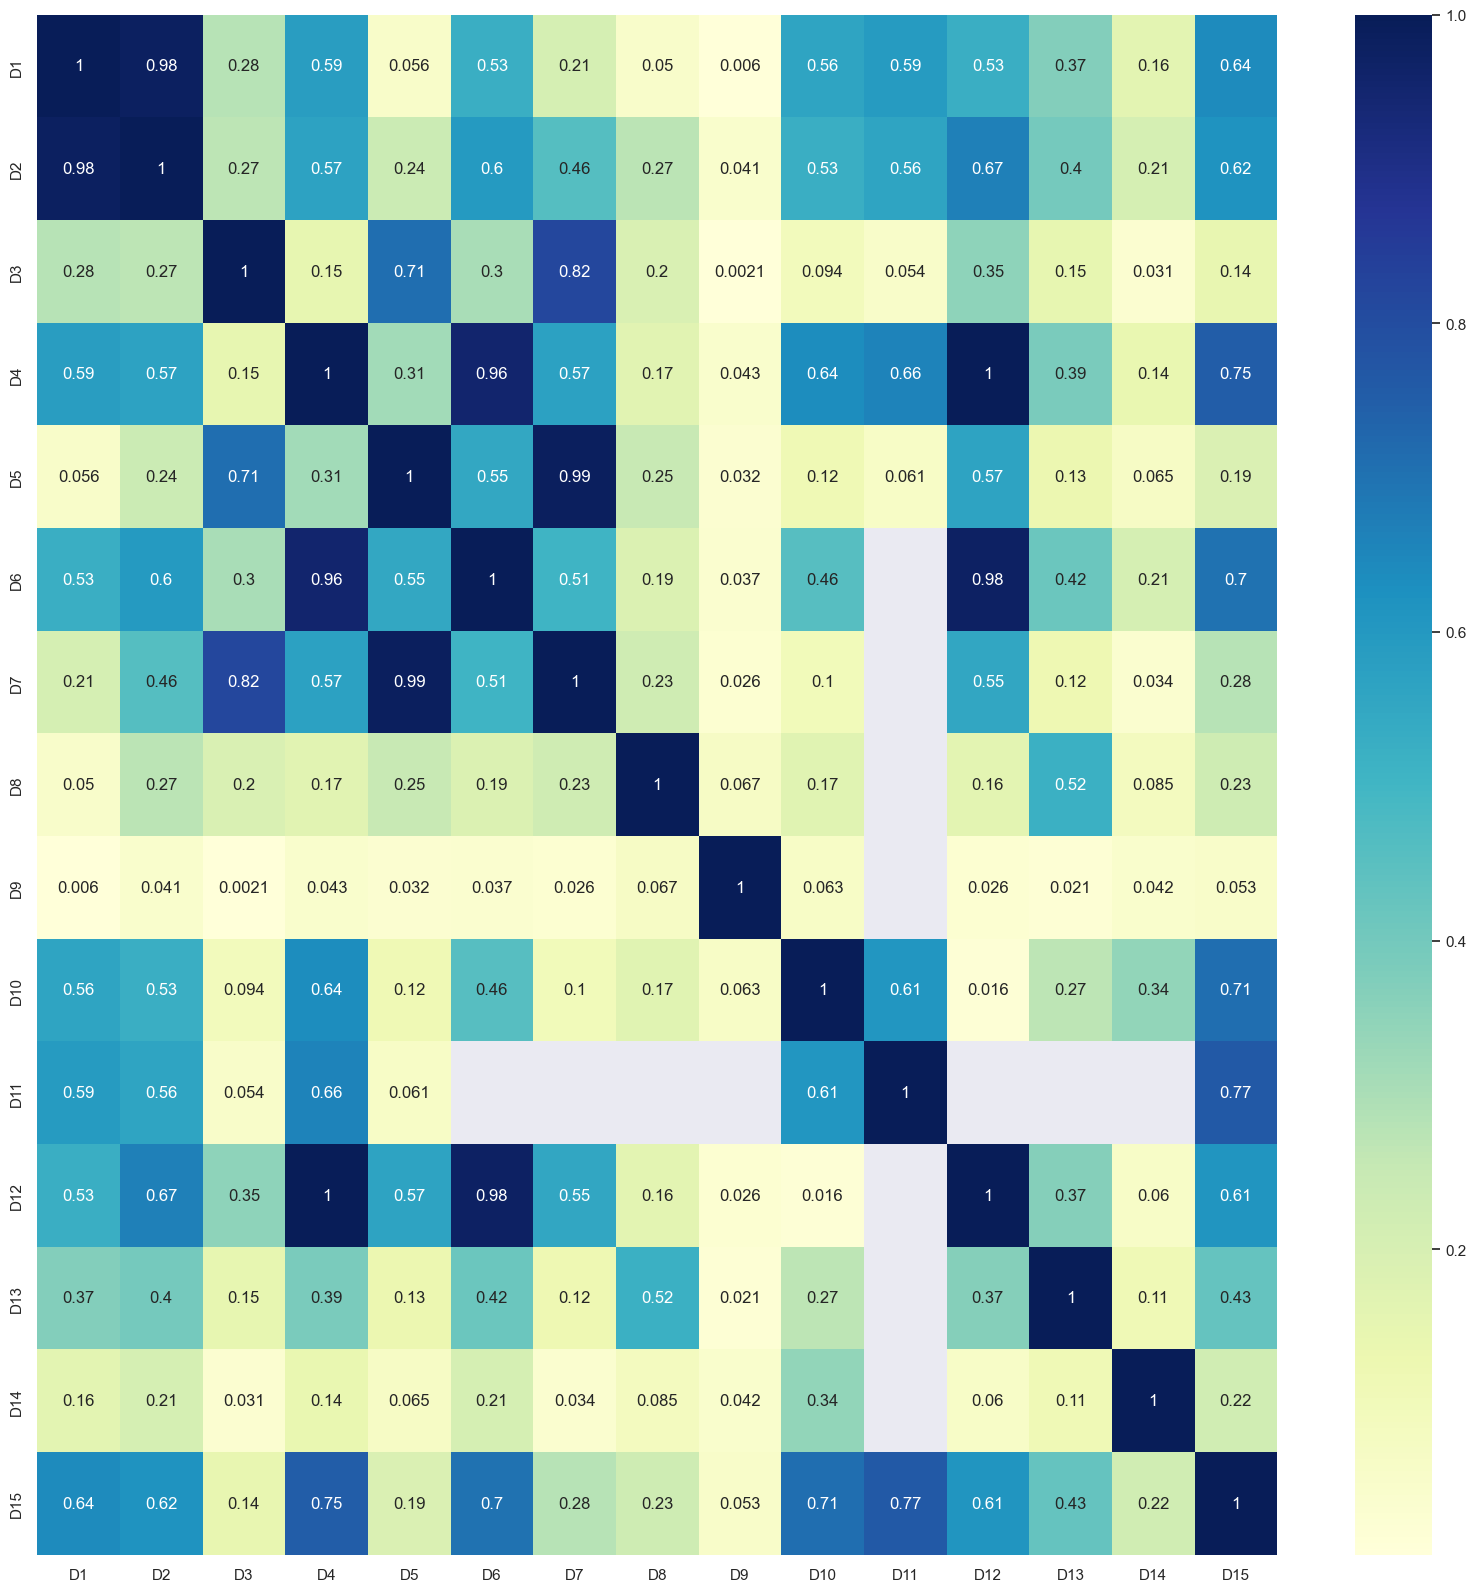

In [27]:
corr_D = train[D_features].corr()
plt.subplots(figsize = (20, 20))
sns.heatmap(corr_D,annot=True, cmap = 'YlGnBu') 
sns.set(font_scale=1)

In [28]:
corr_features(corr_D, 0.9)

Following are highly correlated features: {'D12', 'D6', 'D2', 'D7'}


In [29]:
train["D2"].nunique(), train["D7"].nunique(), train["D12"].nunique(), train["D6"].nunique()

(641, 574, 629, 811)

Here D2, D7, D12 and D6 are highly correlated

So we can keep only one of them and remove the others.

As D6 has the most number of unique values we will keep D6.

#### C Columns

In [30]:
C_features = [ 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'] 

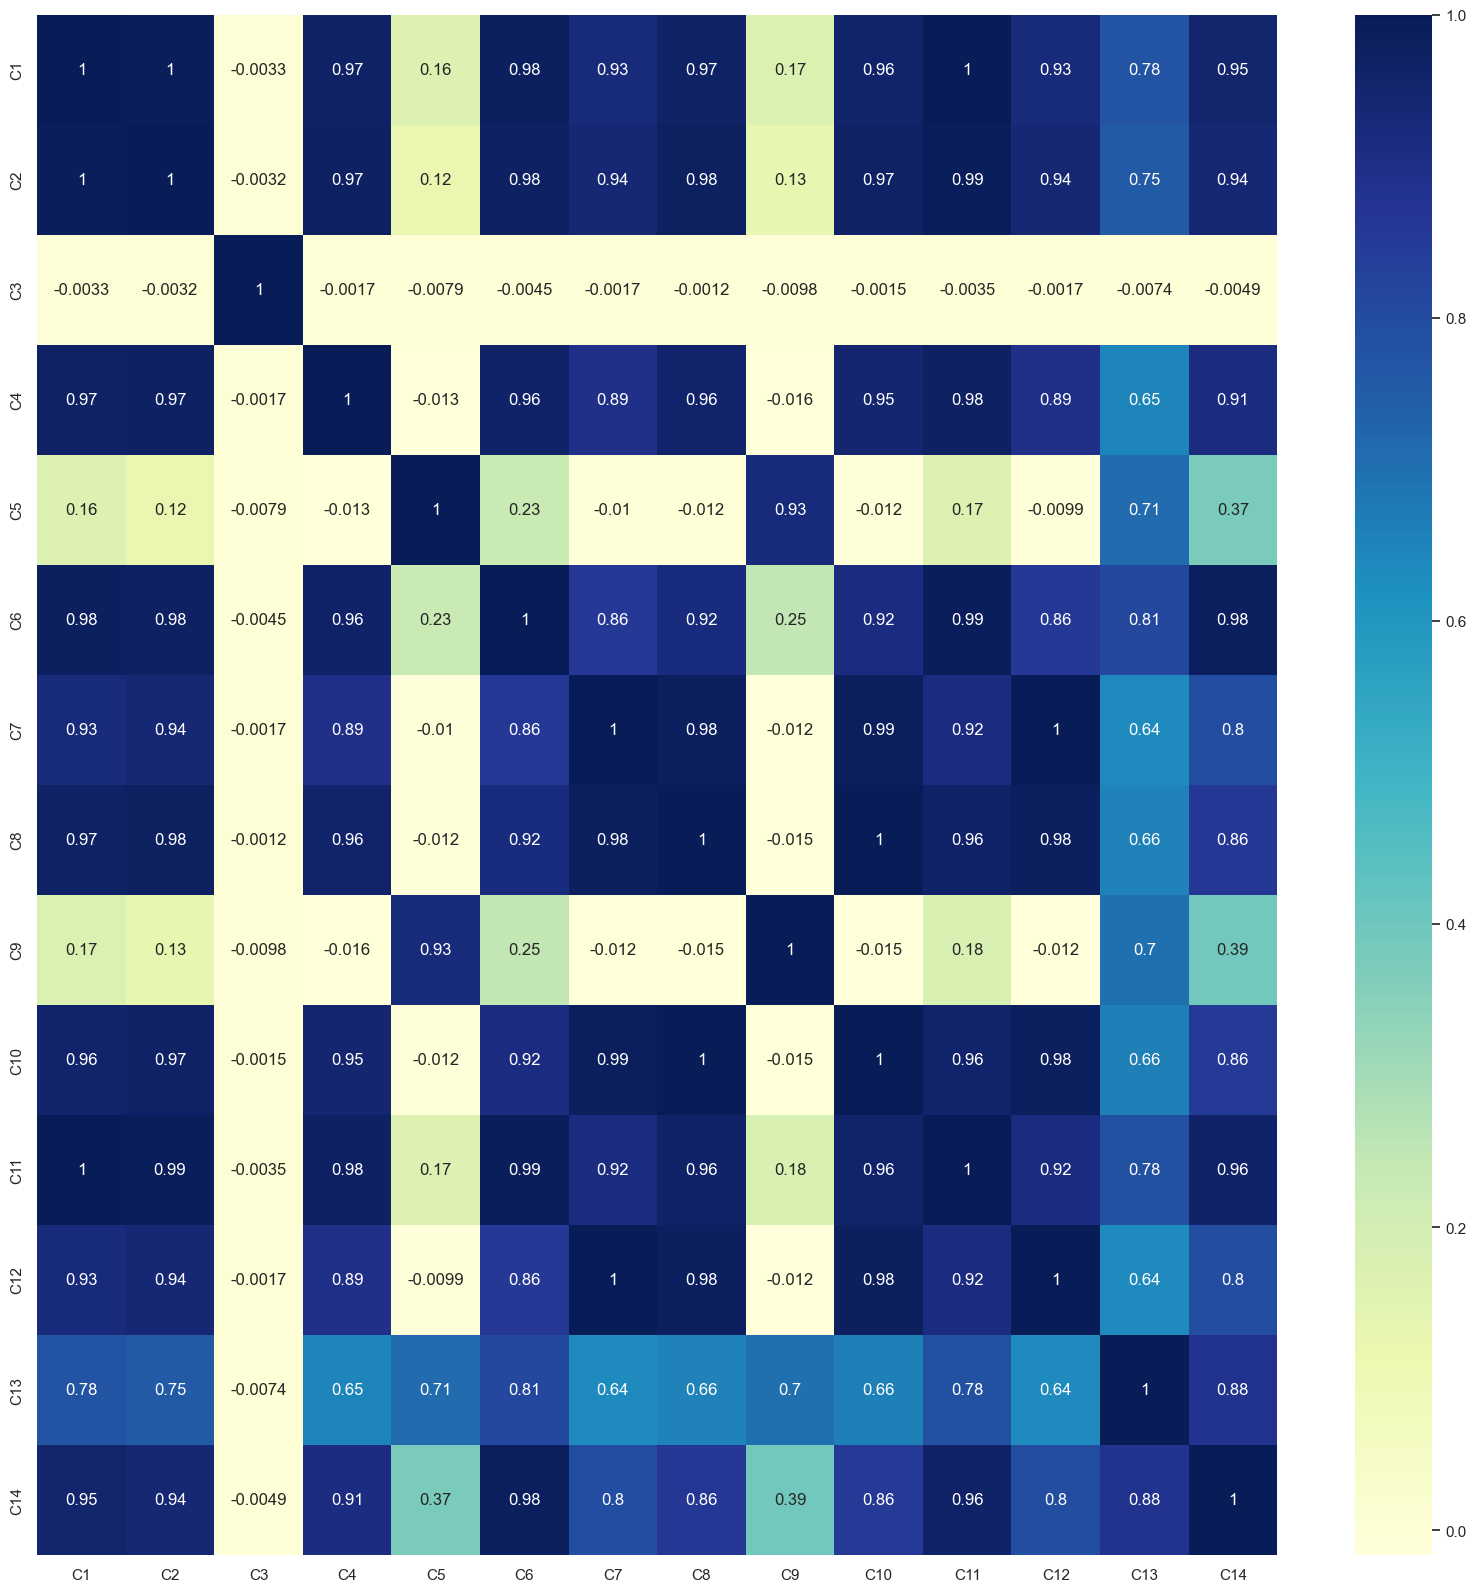

In [31]:
corr_C = train[C_features].corr()
plt.subplots(figsize = (20, 20))
sns.heatmap(corr_C,annot=True, cmap = 'YlGnBu') 
sns.set(font_scale=1)

In [32]:
corr_features(corr_C, 0.9)

Following are highly correlated features: {'C10', 'C11', 'C7', 'C12', 'C6', 'C4', 'C9', 'C14', 'C2', 'C8'}


Here 'C12', 'C9', 'C6', 'C7', 'C2', 'C8', 'C4', 'C11', 'C14', 'C10' are highly correlated

#### id Columns

id_01 to id_11

In [33]:
id_1to11_features = [ 'id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11'] 

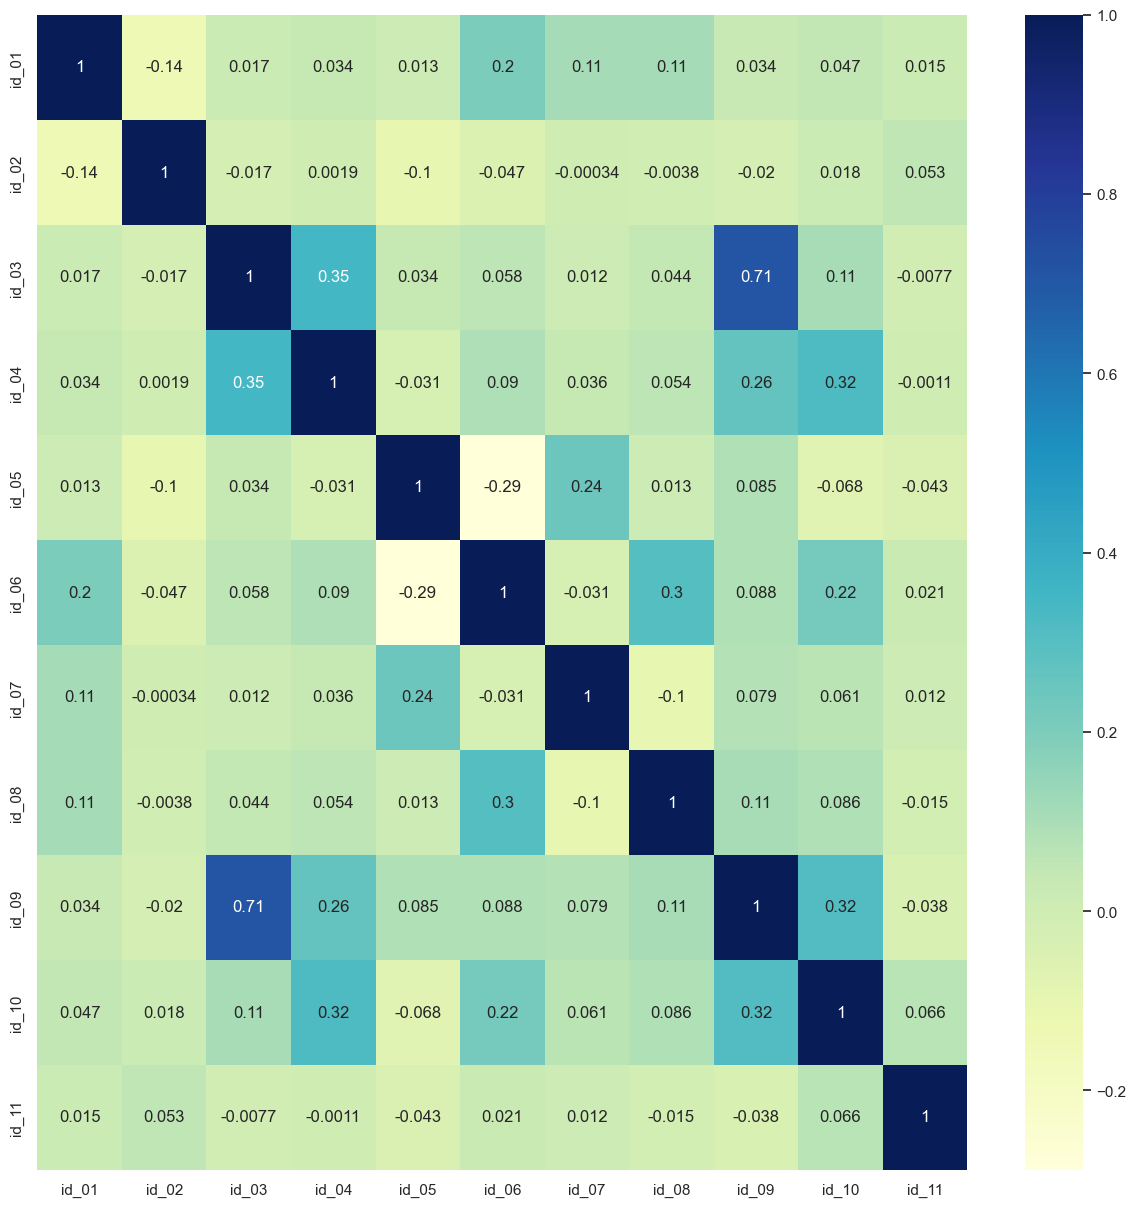

In [34]:
corr_id_1to11 = train[id_1to11_features].corr()
plt.subplots(figsize = (15, 15))
sns.heatmap(corr_id_1to11,annot=True, cmap = 'YlGnBu') 
sns.set(font_scale=1)

In [35]:
corr_features(corr_id_1to11, 0.9)

Following are highly correlated features: set()


none of the following have any high correlation between them

In [36]:
id_rem_columns = ['id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_32']

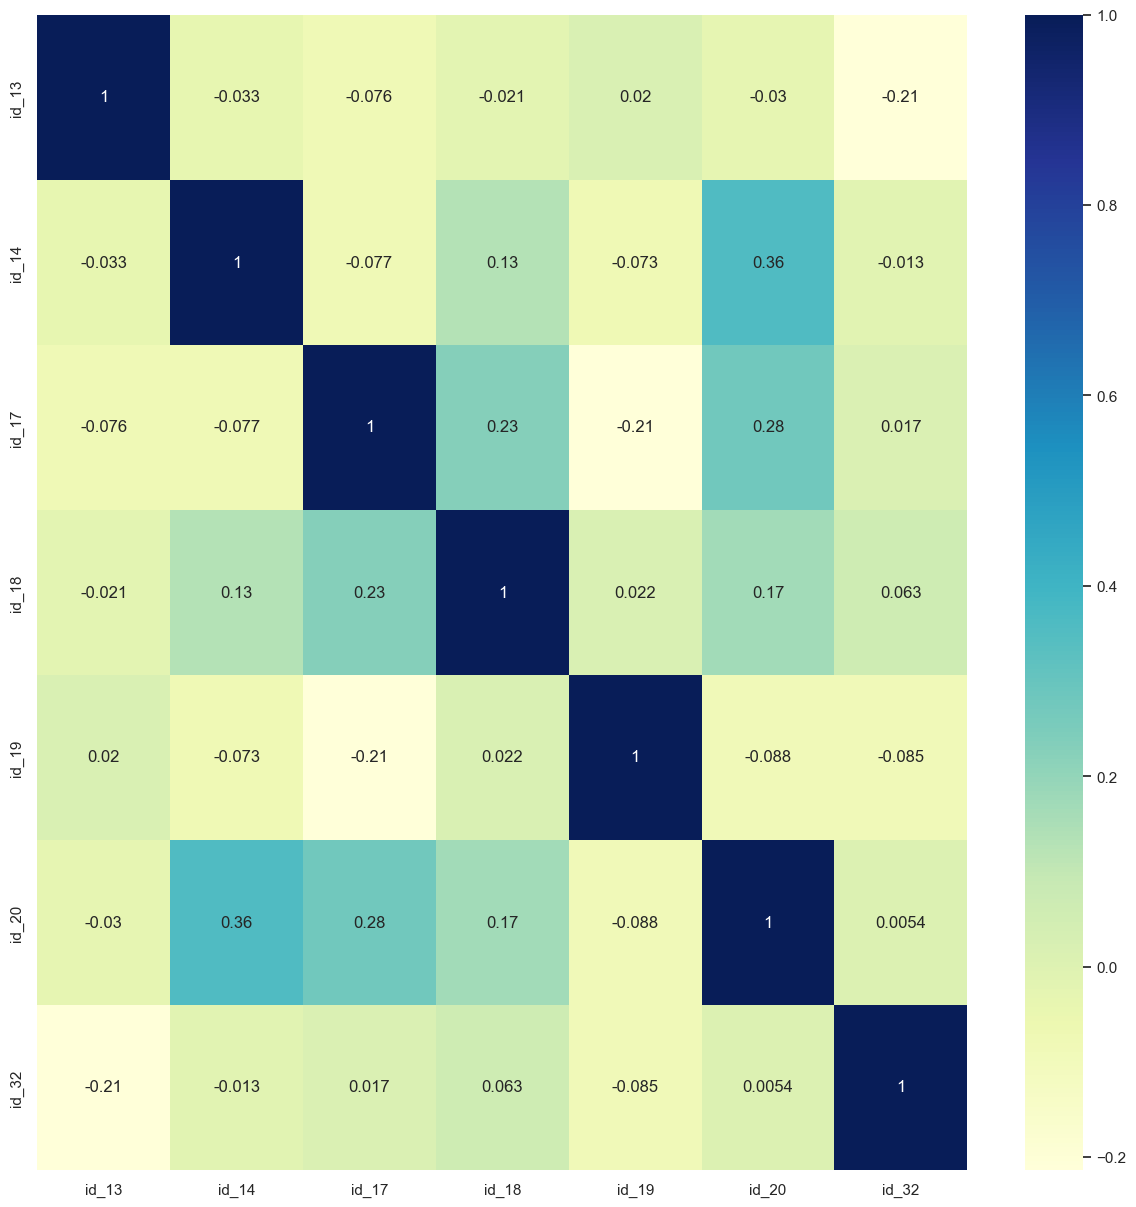

In [37]:
corr_id_rem = train[id_rem_columns].corr()
plt.subplots(figsize = (15, 15))
sns.heatmap(corr_id_rem,annot=True, cmap = 'YlGnBu') 
sns.set(font_scale=1)

In [38]:
corr_features(corr_id_rem, 0.9)

Following are highly correlated features: set()


None are highly correlated

#### Device info

In [39]:
train['device_name'] = train['DeviceInfo'].str.split('/', expand=True)[0]

In [40]:
train["device_name"]

0                NaN
1                NaN
2                NaN
3            Windows
4                NaN
             ...    
442900           NaN
442901           NaN
442902         MacOS
442903    iOS Device
442904       Windows
Name: device_name, Length: 442905, dtype: object

In [41]:
train.loc[train['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
train.loc[train['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
train.loc[train['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
train.loc[train['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
train.loc[train['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
train.loc[train['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
train.loc[train['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
train.loc[train['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
train.loc[train['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
train.loc[train['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
train.loc[train['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

In [42]:
train.loc[train.device_name.isin(train.device_name.value_counts()[train.device_name.value_counts() < 200].index), 'device_name'] = 'Others'

In [43]:
train["device_name"].value_counts()

Windows       35815
iOS Device    14773
MacOS          9434
Samsung        9020
Trident        5605
Others         4086
RV             3330
Motorola       2190
Huawei         1771
LG             1744
Sony            443
ZTE             400
HTC             312
Name: device_name, dtype: int64

In [44]:
train["device_name"].nunique()

13

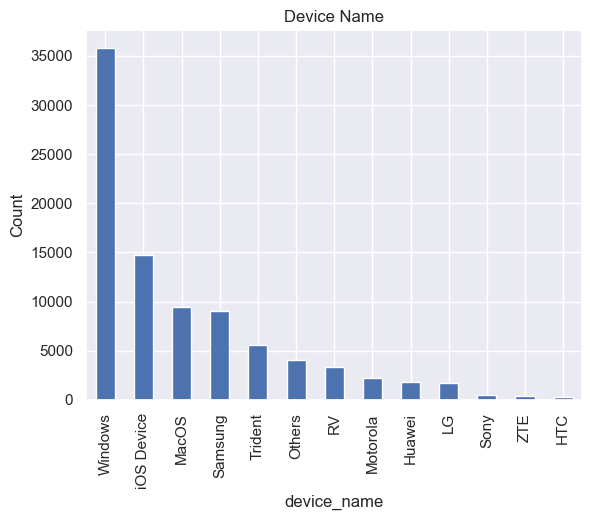

In [45]:
train["device_name"].value_counts().plot(kind='bar')
plt.title("Device Name")
plt.xlabel("device_name")
plt.ylabel("Count")
plt.show()

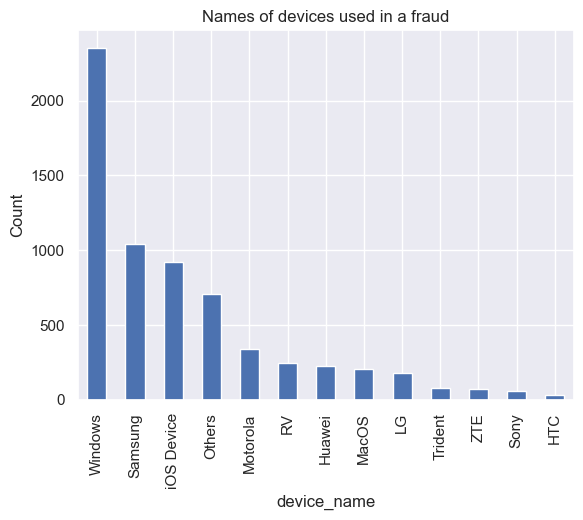

In [46]:
train.loc[train['isFraud'] == 1]["device_name"].value_counts().plot(kind='bar')
plt.title("Names of devices used in a fraud")
plt.xlabel("device_name")
plt.ylabel("Count")
plt.show()

# Pre-processing

### Feature engineering of DeviceInfo

In [47]:
main_df['device_name'] = main_df['DeviceInfo'].str.split('/', expand=True)[0]

In [48]:
main_df.loc[main_df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
main_df.loc[main_df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
main_df.loc[main_df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
main_df.loc[main_df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
main_df.loc[main_df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
main_df.loc[main_df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
main_df.loc[main_df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
main_df.loc[main_df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
main_df.loc[main_df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
main_df.loc[main_df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
main_df.loc[main_df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
main_df.loc[main_df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
main_df.loc[main_df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
main_df.loc[main_df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
main_df.loc[main_df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
main_df.loc[main_df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
main_df.loc[main_df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

In [49]:
main_df.loc[main_df.device_name.isin(main_df.device_name.value_counts()[main_df.device_name.value_counts() < 200].index), 'device_name'] = 'Others'

In [50]:
main_df["device_name"].nunique()

13

### Dropping Columns(Features)

#### TransactionID and TransactionDT

In [51]:
main_df.drop(axis="columns", labels="TransactionID", inplace=True)
main_df.drop(axis="columns", labels="TransactionDT", inplace=True)

#### Categorical

In [52]:
main_df.drop(axis="columns", labels="DeviceInfo", inplace=True)

In [53]:
main_df.drop(axis="columns", labels="DeviceType", inplace=True)

#### Cxx

In [54]:
# main_df.drop(axis="columns", labels="C12", inplace=True)
# main_df.drop(axis="columns", labels="C9", inplace=True)
# main_df.drop(axis="columns", labels="C6", inplace=True)
# main_df.drop(axis="columns", labels="C7", inplace=True)
# main_df.drop(axis="columns", labels="C2", inplace=True)
# main_df.drop(axis="columns", labels="C8", inplace=True)
# main_df.drop(axis="columns", labels="C4", inplace=True)
# main_df.drop(axis="columns", labels="C14", inplace=True)
# main_df.drop(axis="columns", labels="C10", inplace=True)

#### Mx

In [55]:
# main_df.drop(axis="columns", labels="M1", inplace=True)
# main_df.drop(axis="columns", labels="M2", inplace=True)
main_df.drop(axis="columns", labels="M3", inplace=True)
#########################################################
# main_df.drop(axis="columns", labels="M4", inplace=True)
# main_df.drop(axis="columns", labels="M5", inplace=True)
# main_df.drop(axis="columns", labels="M6", inplace=True)
# main_df.drop(axis="columns", labels="M7", inplace=True)
main_df.drop(axis="columns", labels="M8", inplace=True)
main_df.drop(axis="columns", labels="M9", inplace=True)

In [56]:
# main_df["M9"].isna().sum()

#### Dropping dist1 and dist2

In [57]:
# main_df.drop(axis="columns", labels="dist1", inplace=True)
main_df.drop(axis="columns", labels="dist2", inplace=True)

#### Dropping Dxx

In [58]:
main_df.drop(axis="columns", labels="D2", inplace=True)
# main_df.drop(axis="columns", labels="D3", inplace=True)
# main_df.drop(axis="columns", labels="D4", inplace=True)
# main_df.drop(axis="columns", labels="D5", inplace=True)
# main_df.drop(axis="columns", labels="D6", inplace=True)
main_df.drop(axis="columns", labels="D7", inplace=True)
# main_df.drop(axis="columns", labels="D8", inplace=True)
# main_df.drop(axis="columns", labels="D9", inplace=True)

In [59]:
# main_df.drop(axis="columns", labels="D11", inplace=True)
main_df.drop(axis="columns", labels="D12", inplace=True)

# too many null values
main_df.drop(axis="columns", labels="D8", inplace=True)
main_df.drop(axis="columns", labels="D9", inplace=True)
main_df.drop(axis="columns", labels="D13", inplace=True)
main_df.drop(axis="columns", labels="D14", inplace=True)

In [60]:
train["D11"].isna().sum()

209495

#### Dropping 'id_xx' columns

In [61]:
main_df.drop(axis="columns", labels="id_38", inplace=True)

In [62]:
# main_df.drop(axis="columns", labels="id_37", inplace=True)
# main_df.drop(axis="columns", labels="id_36", inplace=True)
# main_df.drop(axis="columns", labels="id_35", inplace=True)
main_df.drop(axis="columns", labels="id_34", inplace=True)
main_df.drop(axis="columns", labels="id_33", inplace=True)

In [63]:
# main_df.drop(axis="columns", labels="id_32", inplace=True)
main_df.drop(axis="columns", labels="id_31", inplace=True)
# main_df.drop(axis="columns", labels="id_30", inplace=True)
# main_df.drop(axis="columns", labels="id_29", inplace=True)
# main_df.drop(axis="columns", labels="id_28", inplace=True)

In [64]:
main_df.drop(axis="columns", labels="id_27", inplace=True)
main_df.drop(axis="columns", labels="id_26", inplace=True)
main_df.drop(axis="columns", labels="id_25", inplace=True)
main_df.drop(axis="columns", labels="id_24", inplace=True)
main_df.drop(axis="columns", labels="id_23", inplace=True)

In [65]:
main_df.drop(axis="columns", labels="id_22", inplace=True)
main_df.drop(axis="columns", labels="id_21", inplace=True)
# main_df.drop(axis="columns", labels="id_20", inplace=True)
# main_df.drop(axis="columns", labels="id_19", inplace=True)
# main_df.drop(axis="columns", labels="id_18", inplace=True)

In [66]:
# main_df.drop(axis="columns", labels="id_17", inplace=True)
# main_df.drop(axis="columns", labels="id_16", inplace=True)
# main_df.drop(axis="columns", labels="id_15", inplace=True)
# main_df.drop(axis="columns", labels="id_14", inplace=True)
# main_df.drop(axis="columns", labels="id_13", inplace=True)

In [67]:
main_df.drop(axis="columns", labels="id_12", inplace=True)
# main_df.drop(axis="columns", labels="id_11", inplace=True)
# main_df.drop(axis="columns", labels="id_10", inplace=True)
# main_df.drop(axis="columns", labels="id_09", inplace=True)
main_df.drop(axis="columns", labels="id_08", inplace=True)

In [68]:
main_df.drop(axis="columns", labels="id_07", inplace=True)
# main_df.drop(axis="columns", labels="id_06", inplace=True)
# main_df.drop(axis="columns", labels="id_05", inplace=True)
# main_df.drop(axis="columns", labels="id_04", inplace=True)
# main_df.drop(axis="columns", labels="id_03", inplace=True)

In [69]:
# main_df.drop(axis="columns", labels="id_02", inplace=True)
# main_df.drop(axis="columns", labels="id_01", inplace=True)

#### Dropping 'Vxxx' columns

In [70]:
main_df.drop(axis="columns", labels="V339", inplace=True)
main_df.drop(axis="columns", labels="V338", inplace=True)
main_df.drop(axis="columns", labels="V337", inplace=True)
main_df.drop(axis="columns", labels="V336", inplace=True)
main_df.drop(axis="columns", labels="V335", inplace=True)

In [71]:
main_df.drop(axis="columns", labels="V334", inplace=True)
main_df.drop(axis="columns", labels="V333", inplace=True)
main_df.drop(axis="columns", labels="V332", inplace=True)
main_df.drop(axis="columns", labels="V331", inplace=True)
main_df.drop(axis="columns", labels="V330", inplace=True)

In [72]:
main_df.drop(axis="columns", labels="V329", inplace=True)
main_df.drop(axis="columns", labels="V328", inplace=True)
main_df.drop(axis="columns", labels="V327", inplace=True)
main_df.drop(axis="columns", labels="V326", inplace=True)
main_df.drop(axis="columns", labels="V325", inplace=True)

In [73]:
main_df.drop(axis="columns", labels="V324", inplace=True)
main_df.drop(axis="columns", labels="V323", inplace=True)
main_df.drop(axis="columns", labels="V322", inplace=True)

In [74]:
main_df.drop(axis="columns", labels="V278", inplace=True)
main_df.drop(axis="columns", labels="V277", inplace=True)
main_df.drop(axis="columns", labels="V276", inplace=True)

In [75]:
main_df.drop(axis="columns", labels="V275", inplace=True)
main_df.drop(axis="columns", labels="V274", inplace=True)
main_df.drop(axis="columns", labels="V273", inplace=True)

In [76]:
main_df.drop(axis="columns", labels="V272", inplace=True)
main_df.drop(axis="columns", labels="V271", inplace=True)
main_df.drop(axis="columns", labels="V270", inplace=True)

In [77]:
main_df.drop(axis="columns", labels="V269", inplace=True)
main_df.drop(axis="columns", labels="V268", inplace=True)
main_df.drop(axis="columns", labels="V267", inplace=True)

In [78]:
main_df.drop(axis="columns", labels="V266", inplace=True)
main_df.drop(axis="columns", labels="V265", inplace=True)
main_df.drop(axis="columns", labels="V264", inplace=True)

In [79]:
main_df.drop(axis="columns", labels="V263", inplace=True)
main_df.drop(axis="columns", labels="V262", inplace=True)
main_df.drop(axis="columns", labels="V261", inplace=True)

In [80]:
main_df.drop(axis="columns", labels="V260", inplace=True)
main_df.drop(axis="columns", labels="V259", inplace=True)
main_df.drop(axis="columns", labels="V258", inplace=True)

In [81]:
main_df.drop(axis="columns", labels="V257", inplace=True)
main_df.drop(axis="columns", labels="V256", inplace=True)
main_df.drop(axis="columns", labels="V255", inplace=True)

In [82]:
main_df.drop(axis="columns", labels="V254", inplace=True)
main_df.drop(axis="columns", labels="V253", inplace=True)
main_df.drop(axis="columns", labels="V252", inplace=True)

In [83]:
main_df.drop(axis="columns", labels="V251", inplace=True)
main_df.drop(axis="columns", labels="V250", inplace=True)
main_df.drop(axis="columns", labels="V249", inplace=True)

In [84]:
main_df.drop(axis="columns", labels="V248", inplace=True)
main_df.drop(axis="columns", labels="V247", inplace=True)
main_df.drop(axis="columns", labels="V246", inplace=True)

In [85]:
main_df.drop(axis="columns", labels="V245", inplace=True)
main_df.drop(axis="columns", labels="V244", inplace=True)
main_df.drop(axis="columns", labels="V243", inplace=True)

In [86]:
main_df.drop(axis="columns", labels="V242", inplace=True)
main_df.drop(axis="columns", labels="V241", inplace=True)
main_df.drop(axis="columns", labels="V240", inplace=True)

In [87]:
main_df.drop(axis="columns", labels="V239", inplace=True)
main_df.drop(axis="columns", labels="V238", inplace=True)
main_df.drop(axis="columns", labels="V237", inplace=True)

In [88]:
main_df.drop(axis="columns", labels="V236", inplace=True)
main_df.drop(axis="columns", labels="V235", inplace=True)
main_df.drop(axis="columns", labels="V234", inplace=True)

In [89]:
main_df.drop(axis="columns", labels="V233", inplace=True)
main_df.drop(axis="columns", labels="V232", inplace=True)
main_df.drop(axis="columns", labels="V231", inplace=True)

In [90]:
main_df.drop(axis="columns", labels="V230", inplace=True)
main_df.drop(axis="columns", labels="V229", inplace=True)
main_df.drop(axis="columns", labels="V228", inplace=True)

In [91]:
main_df.drop(axis="columns", labels="V227", inplace=True)
main_df.drop(axis="columns", labels="V226", inplace=True)
main_df.drop(axis="columns", labels="V225", inplace=True)

In [92]:
main_df.drop(axis="columns", labels="V224", inplace=True)
main_df.drop(axis="columns", labels="V223", inplace=True)
main_df.drop(axis="columns", labels="V222", inplace=True)

In [93]:
main_df.drop(axis="columns", labels="V221", inplace=True)
main_df.drop(axis="columns", labels="V220", inplace=True)
main_df.drop(axis="columns", labels="V219", inplace=True)

In [94]:
main_df.drop(axis="columns", labels="V218", inplace=True)
main_df.drop(axis="columns", labels="V217", inplace=True)
main_df.drop(axis="columns", labels="V216", inplace=True)

In [95]:
main_df.drop(axis="columns", labels="V215", inplace=True)
main_df.drop(axis="columns", labels="V214", inplace=True)
main_df.drop(axis="columns", labels="V213", inplace=True)

In [96]:
main_df.drop(axis="columns", labels="V212", inplace=True)
main_df.drop(axis="columns", labels="V211", inplace=True)
main_df.drop(axis="columns", labels="V210", inplace=True)

In [97]:
main_df.drop(axis="columns", labels="V209", inplace=True)
main_df.drop(axis="columns", labels="V208", inplace=True)
main_df.drop(axis="columns", labels="V207", inplace=True)

In [98]:
main_df.drop(axis="columns", labels="V206", inplace=True)
main_df.drop(axis="columns", labels="V205", inplace=True)
main_df.drop(axis="columns", labels="V204", inplace=True)

In [99]:
main_df.drop(axis="columns", labels="V203", inplace=True)
main_df.drop(axis="columns", labels="V202", inplace=True)
main_df.drop(axis="columns", labels="V201", inplace=True)

In [100]:
main_df.drop(axis="columns", labels="V200", inplace=True)
main_df.drop(axis="columns", labels="V199", inplace=True)
main_df.drop(axis="columns", labels="V198", inplace=True)

In [101]:
main_df.drop(axis="columns", labels="V197", inplace=True)
main_df.drop(axis="columns", labels="V196", inplace=True)
main_df.drop(axis="columns", labels="V195", inplace=True)

In [102]:
main_df.drop(axis="columns", labels="V194", inplace=True)
main_df.drop(axis="columns", labels="V193", inplace=True)
main_df.drop(axis="columns", labels="V192", inplace=True)

In [103]:
main_df.drop(axis="columns", labels="V191", inplace=True)
main_df.drop(axis="columns", labels="V190", inplace=True)
main_df.drop(axis="columns", labels="V189", inplace=True)

In [104]:
main_df.drop(axis="columns", labels="V188", inplace=True)
main_df.drop(axis="columns", labels="V187", inplace=True)
main_df.drop(axis="columns", labels="V186", inplace=True)

In [105]:
main_df.drop(axis="columns", labels="V185", inplace=True)
main_df.drop(axis="columns", labels="V184", inplace=True)
main_df.drop(axis="columns", labels="V183", inplace=True)

In [106]:
main_df.drop(axis="columns", labels="V182", inplace=True)
main_df.drop(axis="columns", labels="V181", inplace=True)
main_df.drop(axis="columns", labels="V180", inplace=True)

In [107]:
main_df.drop(axis="columns", labels="V179", inplace=True)
main_df.drop(axis="columns", labels="V178", inplace=True)
main_df.drop(axis="columns", labels="V177", inplace=True)

In [108]:
main_df.drop(axis="columns", labels="V176", inplace=True)
main_df.drop(axis="columns", labels="V175", inplace=True)
main_df.drop(axis="columns", labels="V174", inplace=True)

In [109]:
main_df.drop(axis="columns", labels="V173", inplace=True)
main_df.drop(axis="columns", labels="V172", inplace=True)
main_df.drop(axis="columns", labels="V171", inplace=True)

In [110]:
main_df.drop(axis="columns", labels="V170", inplace=True)
main_df.drop(axis="columns", labels="V169", inplace=True)
main_df.drop(axis="columns", labels="V168", inplace=True)

In [111]:
main_df.drop(axis="columns", labels="V167", inplace=True)
main_df.drop(axis="columns", labels="V166", inplace=True)
main_df.drop(axis="columns", labels="V165", inplace=True)

In [112]:
main_df.drop(axis="columns", labels="V164", inplace=True)
main_df.drop(axis="columns", labels="V163", inplace=True)
main_df.drop(axis="columns", labels="V162", inplace=True)

In [113]:
main_df.drop(axis="columns", labels="V161", inplace=True)
main_df.drop(axis="columns", labels="V160", inplace=True)
main_df.drop(axis="columns", labels="V159", inplace=True)

In [114]:
main_df.drop(axis="columns", labels="V158", inplace=True)
main_df.drop(axis="columns", labels="V157", inplace=True)
main_df.drop(axis="columns", labels="V156", inplace=True)

In [115]:
main_df.drop(axis="columns", labels="V155", inplace=True)
main_df.drop(axis="columns", labels="V154", inplace=True)
main_df.drop(axis="columns", labels="V153", inplace=True)

In [116]:
main_df.drop(axis="columns", labels="V152", inplace=True)
main_df.drop(axis="columns", labels="V151", inplace=True)
main_df.drop(axis="columns", labels="V150", inplace=True)

In [117]:
main_df.drop(axis="columns", labels="V149", inplace=True)
main_df.drop(axis="columns", labels="V148", inplace=True)
main_df.drop(axis="columns", labels="V147", inplace=True)

In [118]:
main_df.drop(axis="columns", labels="V146", inplace=True)
main_df.drop(axis="columns", labels="V145", inplace=True)
main_df.drop(axis="columns", labels="V144", inplace=True)

In [119]:
main_df.drop(axis="columns", labels="V143", inplace=True)
main_df.drop(axis="columns", labels="V142", inplace=True)
main_df.drop(axis="columns", labels="V141", inplace=True)

In [120]:
main_df.drop(axis="columns", labels="V140", inplace=True)
main_df.drop(axis="columns", labels="V139", inplace=True)
main_df.drop(axis="columns", labels="V138", inplace=True)

In [121]:
main_df.drop(axis="columns", labels="V52", inplace=True)
main_df.drop(axis="columns", labels="V51", inplace=True)
main_df.drop(axis="columns", labels="V50", inplace=True)

In [122]:
main_df.drop(axis="columns", labels="V49", inplace=True)
main_df.drop(axis="columns", labels="V48", inplace=True)
main_df.drop(axis="columns", labels="V47", inplace=True)

In [123]:
main_df.drop(axis="columns", labels="V46", inplace=True)
main_df.drop(axis="columns", labels="V45", inplace=True)
main_df.drop(axis="columns", labels="V44", inplace=True)

In [124]:
main_df.drop(axis="columns", labels="V43", inplace=True)
main_df.drop(axis="columns", labels="V42", inplace=True)
main_df.drop(axis="columns", labels="V41", inplace=True)

In [125]:
main_df.drop(axis="columns", labels="V40", inplace=True)
main_df.drop(axis="columns", labels="V39", inplace=True)
main_df.drop(axis="columns", labels="V38", inplace=True)

In [126]:
main_df.drop(axis="columns", labels="V37", inplace=True)
main_df.drop(axis="columns", labels="V36", inplace=True)
main_df.drop(axis="columns", labels="V35", inplace=True)

In [127]:
main_df.drop(axis="columns", labels="V11", inplace=True)
main_df.drop(axis="columns", labels="V10", inplace=True)
main_df.drop(axis="columns", labels="V9", inplace=True)

In [128]:
main_df.drop(axis="columns", labels="V8", inplace=True)
main_df.drop(axis="columns", labels="V7", inplace=True)
main_df.drop(axis="columns", labels="V6", inplace=True)

In [129]:
main_df.drop(axis="columns", labels="V5", inplace=True)
main_df.drop(axis="columns", labels="V4", inplace=True)
main_df.drop(axis="columns", labels="V3", inplace=True)

In [130]:
main_df.drop(axis="columns", labels="V2", inplace=True)
main_df.drop(axis="columns", labels="V1", inplace=True)

### Replacing NULL values by something

In [131]:
main_df["isFraud"].isna().sum()
main_df["isFraud"].fillna(0, inplace=True)

#### For Vxxx columns

If more outliers than replace by median

If less outliers replace by mean

In [132]:
main_df["V321"].fillna(main_df["V321"].median(), inplace=True)
main_df["V320"].fillna(main_df["V320"].median(), inplace=True)
main_df["V319"].fillna(main_df["V319"].median(), inplace=True)
main_df["V318"].fillna(main_df["V318"].median(), inplace=True)
main_df["V317"].fillna(main_df["V317"].median(), inplace=True)

In [133]:
main_df["V303"].isna().sum()

12

In [134]:
main_df["V316"].fillna(main_df["V316"].median(), inplace=True)
main_df["V315"].fillna(main_df["V315"].median(), inplace=True)
main_df["V314"].fillna(main_df["V314"].median(), inplace=True)
main_df["V313"].fillna(main_df["V313"].median(), inplace=True)
main_df["V312"].fillna(main_df["V312"].median(), inplace=True)

In [135]:
main_df["V311"].fillna(main_df["V311"].median(), inplace=True)
main_df["V310"].fillna(main_df["V310"].median(), inplace=True)
main_df["V309"].fillna(main_df["V309"].median(), inplace=True)
main_df["V308"].fillna(main_df["V308"].median(), inplace=True)
main_df["V307"].fillna(main_df["V307"].median(), inplace=True)

In [136]:
main_df["V306"].fillna(main_df["V306"].median(), inplace=True)
main_df["V305"].fillna(main_df["V305"].median(), inplace=True)
main_df["V304"].fillna(main_df["V304"].median(), inplace=True)
main_df["V303"].fillna(main_df["V303"].median(), inplace=True)
main_df["V302"].fillna(main_df["V302"].median(), inplace=True)

In [137]:
main_df["V301"].fillna(main_df["V301"].median(), inplace=True)
main_df["V300"].fillna(main_df["V300"].median(), inplace=True)
main_df["V299"].fillna(main_df["V299"].median(), inplace=True)
main_df["V298"].fillna(main_df["V298"].median(), inplace=True)
main_df["V297"].fillna(main_df["V297"].median(), inplace=True)

In [138]:
main_df["V296"].fillna(main_df["V296"].median(), inplace=True)
main_df["V295"].fillna(main_df["V295"].median(), inplace=True)
main_df["V294"].fillna(main_df["V294"].median(), inplace=True)
main_df["V293"].fillna(main_df["V293"].median(), inplace=True)
main_df["V292"].fillna(main_df["V292"].median(), inplace=True)

In [139]:
main_df["V295"].isna().sum()

0

In [140]:
main_df["V291"].fillna(main_df["V291"].median(), inplace=True)
main_df["V290"].fillna(main_df["V290"].median(), inplace=True)
main_df["V289"].fillna(main_df["V289"].median(), inplace=True)
main_df["V288"].fillna(main_df["V288"].median(), inplace=True)
main_df["V287"].fillna(main_df["V287"].median(), inplace=True)

In [141]:
main_df["V284"].isna().sum()

12

In [142]:
main_df["V286"].fillna(main_df["V286"].median(), inplace=True)
main_df["V285"].fillna(main_df["V285"].median(), inplace=True)
main_df["V284"].fillna(main_df["V284"].median(), inplace=True)

In [143]:
main_df["V281"].fillna(main_df["V281"].median(), inplace=True)
main_df["V280"].fillna(main_df["V280"].median(), inplace=True)
main_df["V279"].fillna(main_df["V279"].median(), inplace=True)

In [144]:
main_df["V137"].isna().sum()

314

In [145]:
main_df["V137"].fillna(main_df["V137"].median(), inplace=True)
main_df["V136"].fillna(main_df["V136"].median(), inplace=True)
main_df["V135"].fillna(main_df["V135"].median(), inplace=True)

In [146]:
main_df["V134"].fillna(main_df["V134"].median(), inplace=True)
main_df["V133"].fillna(main_df["V133"].median(), inplace=True)
main_df["V132"].fillna(main_df["V132"].median(), inplace=True)

In [147]:
main_df["V131"].fillna(main_df["V131"].median(), inplace=True)
main_df["V130"].fillna(main_df["V130"].median(), inplace=True)
main_df["V129"].fillna(main_df["V129"].median(), inplace=True)

In [148]:
main_df["V128"].fillna(main_df["V128"].median(), inplace=True)
main_df["V127"].fillna(main_df["V127"].median(), inplace=True)
main_df["V126"].fillna(main_df["V126"].median(), inplace=True)

In [149]:
main_df["V125"].fillna(main_df["V125"].median(), inplace=True)
main_df["V124"].fillna(main_df["V124"].median(), inplace=True)
main_df["V123"].fillna(main_df["V123"].median(), inplace=True)

In [150]:
main_df["V122"].fillna(main_df["V122"].median(), inplace=True)
main_df["V121"].fillna(main_df["V121"].median(), inplace=True)
main_df["V120"].fillna(main_df["V120"].median(), inplace=True)

In [151]:
main_df["V122"].isna().sum()

0

In [152]:
main_df["V119"].fillna(main_df["V119"].median(), inplace=True)
main_df["V118"].fillna(main_df["V118"].median(), inplace=True)
main_df["V117"].fillna(main_df["V117"].median(), inplace=True)

In [153]:
main_df["V116"].fillna(main_df["V116"].median(), inplace=True)
main_df["V115"].fillna(main_df["V115"].median(), inplace=True)
main_df["V114"].fillna(main_df["V114"].median(), inplace=True)

In [154]:
main_df["V113"].fillna(main_df["V113"].median(), inplace=True)
main_df["V112"].fillna(main_df["V112"].median(), inplace=True)
main_df["V111"].fillna(main_df["V111"].median(), inplace=True)

In [155]:
main_df["V110"].fillna(main_df["V110"].median(), inplace=True)
main_df["V109"].fillna(main_df["V109"].median(), inplace=True)
main_df["V108"].fillna(main_df["V108"].median(), inplace=True)

V106 had 441649 '1.0's and only 191 '0's

In [156]:
main_df["V107"].fillna(main_df["V107"].median(), inplace=True)
main_df["V106"].fillna(main_df["V106"].median(), inplace=True)
main_df["V105"].fillna(main_df["V105"].median(), inplace=True)

In [157]:
main_df["V104"].fillna(main_df["V104"].median(), inplace=True)
main_df["V103"].fillna(main_df["V103"].median(), inplace=True)
main_df["V102"].fillna(main_df["V102"].median(), inplace=True)

In [158]:
main_df["V101"].fillna(main_df["V101"].median(), inplace=True)
main_df["V100"].fillna(main_df["V100"].median(), inplace=True)
main_df["V99"].fillna(main_df["V99"].median(), inplace=True)

In [159]:
main_df["V282"].isna().sum()

1269

In [160]:
main_df["V98"].fillna(main_df["V98"].median(), inplace=True)
main_df["V97"].fillna(main_df["V97"].median(), inplace=True)
main_df["V96"].fillna(main_df["V96"].median(), inplace=True)

In [161]:
main_df["V95"].fillna(main_df["V95"].median(), inplace=True)
main_df["V282"].fillna(main_df["V282"].median(), inplace=True)
main_df["V283"].fillna(main_df["V283"].median(), inplace=True)

#### Every column except Vxxx

In [162]:
main_df["dist1"].fillna(main_df["dist1"].median(), inplace=True)

In [163]:
main_df["card4"].fillna("visa", inplace=True)
main_df["card6"].fillna("debit", inplace=True)
main_df["card2"].fillna(main_df["card2"].median(), inplace=True)
main_df["card3"].fillna(main_df["card3"].median(), inplace=True)
main_df["card5"].fillna(main_df["card5"].median(), inplace=True)

In [164]:
main_df["addr1"].fillna(main_df["addr1"].median(), inplace=True)
main_df["addr2"].fillna(main_df["addr2"].median(), inplace=True)

In [165]:
main_df["D1"].fillna(main_df["D1"].median(), inplace=True)
main_df["D3"].fillna(main_df["D3"].median(), inplace=True)
main_df["D4"].fillna(main_df["D4"].median(), inplace=True)
main_df["D5"].fillna(main_df["D5"].median(), inplace=True)
main_df["D6"].fillna(main_df["D6"].median(), inplace=True)
main_df["D10"].fillna(main_df["D10"].median(), inplace=True)
main_df["D11"].fillna(main_df["D11"].median(), inplace=True)
main_df["D15"].fillna(main_df["D15"].median(), inplace=True)

In [166]:
main_df["P_emaildomain"].fillna("gmail.com", inplace=True)

In [167]:
main_df["R_emaildomain"].fillna("gmail.com", inplace=True)

In [168]:
main_df["M1"].fillna("T", inplace=True)
main_df["M2"].fillna("T", inplace=True)
main_df["M4"].fillna("M0", inplace=True)
main_df["M5"].fillna("F", inplace=True)
main_df["M6"].fillna("F", inplace=True)
main_df["M7"].fillna("F", inplace=True)

In [169]:
main_df["id_01"].fillna(main_df["id_01"].median(), inplace=True)
main_df["id_02"].fillna(main_df["id_02"].median(), inplace=True)
main_df["id_03"].fillna(main_df["id_03"].median(), inplace=True)
main_df["id_04"].fillna(main_df["id_04"].median(), inplace=True)
main_df["id_05"].fillna(main_df["id_05"].median(), inplace=True)
main_df["id_06"].fillna(main_df["id_06"].median(), inplace=True)
main_df["id_09"].fillna(main_df["id_09"].median(), inplace=True)
main_df["id_10"].fillna(main_df["id_10"].median(), inplace=True)
main_df["id_11"].fillna(main_df["id_11"].median(), inplace=True)
main_df["id_13"].fillna(main_df["id_13"].median(), inplace=True)
main_df["id_14"].fillna(main_df["id_14"].median(), inplace=True)
main_df["id_17"].fillna(main_df["id_17"].median(), inplace=True)
main_df["id_18"].fillna(main_df["id_18"].median(), inplace=True)
main_df["id_19"].fillna(main_df["id_19"].median(), inplace=True)
main_df["id_20"].fillna(main_df["id_20"].median(), inplace=True)
main_df["id_32"].fillna(main_df["id_32"].median(), inplace=True)

In [170]:
# main_df["id_12"].fillna("Unknown", inplace=True)
main_df["id_15"].fillna("Unknown", inplace=True)
main_df["id_16"].fillna("Unknown", inplace=True)
main_df["id_28"].fillna("Unknown", inplace=True)
main_df["id_29"].fillna("Unknown", inplace=True)
main_df["id_30"].fillna("Windows 10", inplace=True)
# main_df["id_31"].fillna("chrome 63.0", inplace=True)
main_df["id_35"].fillna("None", inplace=True)
main_df["id_36"].fillna("F", inplace=True)
main_df["id_37"].fillna("T", inplace=True)

In [171]:
train["id_30"].value_counts()

Windows 10          15858
Windows 7            9841
iOS 11.1.2           2790
iOS 11.2.1           2776
Android 7.0          2151
                    ...  
other                   9
Windows                 3
Mac OS X 10_13_5        2
iOS 11.4.0              1
iOS 11.4.1              1
Name: id_30, Length: 75, dtype: int64

#### For Vxxx feature

If more outliers than replace by median

If less outliers replace by mean

In [172]:
main_df["V94"].fillna(main_df["V94"].median(), inplace=True)

In [173]:
main_df["V93"].fillna(main_df["V93"].median(), inplace=True)
main_df["V94"].fillna(main_df["V94"].median(), inplace=True)
main_df["V92"].fillna(main_df["V92"].median(), inplace=True)
main_df["V91"].fillna(main_df["V91"].median(), inplace=True)
main_df["V90"].fillna(main_df["V90"].median(), inplace=True)

In [174]:
main_df["V89"].fillna(main_df["V89"].median(), inplace=True)
main_df["V88"].fillna(main_df["V88"].median(), inplace=True)
main_df["V87"].fillna(main_df["V87"].median(), inplace=True)
main_df["V86"].fillna(main_df["V86"].median(), inplace=True)
main_df["V85"].fillna(main_df["V85"].median(), inplace=True)

In [175]:
main_df["V84"].fillna(main_df["V84"].median(), inplace=True)
main_df["V83"].fillna(main_df["V83"].median(), inplace=True)
main_df["V82"].fillna(main_df["V82"].median(), inplace=True)
main_df["V81"].fillna(main_df["V81"].median(), inplace=True)
main_df["V80"].fillna(main_df["V80"].median(), inplace=True)

In [176]:
main_df["V79"].fillna(main_df["V79"].median(), inplace=True)
main_df["V78"].fillna(main_df["V78"].median(), inplace=True)
main_df["V77"].fillna(main_df["V77"].median(), inplace=True)
main_df["V76"].fillna(main_df["V76"].median(), inplace=True)
main_df["V75"].fillna(main_df["V75"].median(), inplace=True)

In [177]:
main_df["V74"].fillna(main_df["V74"].median(), inplace=True)
main_df["V73"].fillna(main_df["V73"].median(), inplace=True)
main_df["V72"].fillna(main_df["V72"].median(), inplace=True)
main_df["V71"].fillna(main_df["V71"].median(), inplace=True)
main_df["V70"].fillna(main_df["V70"].median(), inplace=True)

In [178]:
main_df["V69"].fillna(main_df["V69"].median(), inplace=True)
main_df["V68"].fillna(main_df["V68"].median(), inplace=True)
main_df["V67"].fillna(main_df["V67"].median(), inplace=True)
main_df["V66"].fillna(main_df["V66"].median(), inplace=True)
main_df["V65"].fillna(main_df["V65"].median(), inplace=True)

In [179]:
main_df["V64"].fillna(main_df["V64"].median(), inplace=True)
main_df["V63"].fillna(main_df["V63"].median(), inplace=True)
main_df["V62"].fillna(main_df["V62"].median(), inplace=True)
main_df["V61"].fillna(main_df["V61"].median(), inplace=True)
main_df["V60"].fillna(main_df["V60"].median(), inplace=True)

In [180]:
main_df["V59"].fillna(main_df["V59"].median(), inplace=True)
main_df["V58"].fillna(main_df["V58"].median(), inplace=True)
main_df["V57"].fillna(main_df["V57"].median(), inplace=True)
main_df["V56"].fillna(main_df["V56"].median(), inplace=True)
main_df["V55"].fillna(main_df["V55"].median(), inplace=True)

In [181]:
main_df["V54"].fillna(main_df["V54"].median(), inplace=True)
main_df["V53"].fillna(main_df["V53"].median(), inplace=True)

In [182]:
main_df["V34"].fillna(main_df["V34"].median(), inplace=True)
main_df["V33"].fillna(main_df["V33"].median(), inplace=True)
main_df["V32"].fillna(main_df["V32"].median(), inplace=True)
main_df["V31"].fillna(main_df["V31"].median(), inplace=True)
main_df["V30"].fillna(main_df["V30"].median(), inplace=True)

In [183]:
main_df["V29"].fillna(main_df["V29"].median(), inplace=True)
main_df["V28"].fillna(main_df["V28"].median(), inplace=True)
main_df["V27"].fillna(main_df["V27"].median(), inplace=True)
main_df["V26"].fillna(main_df["V26"].median(), inplace=True)
main_df["V25"].fillna(main_df["V25"].median(), inplace=True)

In [184]:
main_df["V24"].fillna(main_df["V24"].median(), inplace=True)
main_df["V23"].fillna(main_df["V23"].median(), inplace=True)
main_df["V22"].fillna(main_df["V22"].median(), inplace=True)
main_df["V21"].fillna(main_df["V21"].median(), inplace=True)
main_df["V20"].fillna(main_df["V20"].median(), inplace=True)

In [185]:
main_df["V19"].fillna(main_df["V19"].median(), inplace=True)
main_df["V18"].fillna(main_df["V18"].median(), inplace=True)
main_df["V17"].fillna(main_df["V17"].median(), inplace=True)
main_df["V16"].fillna(main_df["V16"].median(), inplace=True)
main_df["V15"].fillna(main_df["V15"].median(), inplace=True)

In [186]:
main_df["V14"].fillna(main_df["V14"].median(), inplace=True)
main_df["V13"].fillna(main_df["V13"].median(), inplace=True)
main_df["V12"].fillna(main_df["V12"].median(), inplace=True)

In [187]:
# main_df["V11"].isna().sum()

In [188]:
# main_df["V11"].median()

In [189]:
# main_df["V15"].value_counts()

### Label encoding

In [190]:
le = LabelEncoder()

In [191]:
# column_names_to_label_encode = ["id_30"]

In [192]:
main_df['id_30'] = le.fit_transform(main_df['id_30'])

In [193]:
main_df['R_emaildomain'] = le.fit_transform(main_df['R_emaildomain'])

In [194]:
main_df['P_emaildomain'] = le.fit_transform(main_df['P_emaildomain'])

In [195]:
main_df['P_emaildomain'].dtype

dtype('int32')

### Binary encoding (yet to do)

### Frequency encoding (not sure)

### Target encoding (yet to do)

### One-Hot encoding

In [196]:
column_names_to_one_hot = ["ProductCD", "card4", "card6", "M1", "M2", "M4", "M5", "M6", "M7", "id_15", "id_16", "id_28", "id_29", "id_35", "id_36", "id_37", "device_name"]

In [197]:
main_df = pd.get_dummies(main_df, columns=column_names_to_one_hot)

In [198]:
main_df.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,R_emaildomain,...,device_name_MacOS,device_name_Motorola,device_name_Others,device_name_RV,device_name_Samsung,device_name_Sony,device_name_Trident,device_name_Windows,device_name_ZTE,device_name_iOS Device
0,325.000,12932,361.0,150.0,226.0,126.0,87.0,24.0,16,16,...,0,0,0,0,0,0,0,0,0,0
1,37.257,14276,177.0,185.0,137.0,299.0,87.0,8.0,16,16,...,0,0,0,0,1,0,0,0,0,0
2,100.000,16506,554.0,150.0,226.0,299.0,87.0,8.0,16,16,...,0,0,0,0,0,0,0,1,0,0
3,57.950,9500,321.0,150.0,226.0,441.0,87.0,295.0,16,16,...,0,0,0,0,0,0,0,0,0,0
4,34.258,15885,545.0,185.0,138.0,284.0,60.0,8.0,19,19,...,0,0,0,0,0,0,0,0,0,0


In [199]:
# main_df["D1"].isna().sum()

In [200]:
# main_df["D1"].value_counts()

### Standardization

In [201]:
# df = main_df.copy()

In [202]:
# df.loc[:, ~df.columns.isin(['isFraud', 'ind'])] = (df.loc[:, ~df.columns.isin(['isFraud', 'ind'])] - df.loc[:, ~df.columns.isin(['isFraud', 'ind'])].mean()) / df.loc[:, ~df.columns.isin(['isFraud', 'ind'])].std()

In [203]:
# df.loc[:, ~df.columns.isin(['isFraud', 'ind'])].head()

In [204]:
# df.head()

In [205]:
# df["isFraud"].head()

### Seperating test-train data

In [206]:
test_standard, train_standard = main_df[main_df["ind"].eq("test")], main_df[main_df["ind"].eq("train")]

In [207]:
test_standard.drop(axis="columns", labels="ind", inplace=True)
train_standard.drop(axis="columns", labels="ind", inplace=True)

C:\Users\Prem Shah\AppData\Local\Temp\ipykernel_10004\3193864518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_standard.drop(axis="columns", labels="ind", inplace=True)
C:\Users\Prem Shah\AppData\Local\Temp\ipykernel_10004\3193864518.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_standard.drop(axis="columns", labels="ind", inplace=True)


In [208]:
test_standard.shape

(147635, 259)

In [209]:
train_standard.shape

(442905, 259)

In [210]:
train_standard["isFraud"].value_counts()

0.0    427408
1.0     15497
Name: isFraud, dtype: int64

### Skew detection

In [211]:
# sns.distplot(train_standard['TransactionAmt'])

In [212]:
# new_trans_amt = np.log(train_standard["TransactionAmt"])

In [213]:
# sns.distplot(new_trans_amt)

In [214]:
# train_standard.head()

In [215]:
# train_standard.insert(1, "new_trans_amt", new_trans_amt)

In [216]:
# train_standard.head()

In [217]:
# train_standard.drop(axis="columns", labels="TransactionAmt", inplace=True)

### Splitting into feature and target columns

In [218]:
X_train = train_standard.drop(axis="columns", labels="isFraud").to_numpy().astype(np.float64)
y_train = train_standard["isFraud"].to_numpy().astype(np.float64)
X_test = test_standard.drop(axis="columns", labels="isFraud").to_numpy().astype(np.float64)

# Re-Sampling

In [272]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [273]:
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [274]:
pipeline = Pipeline(steps=[('o', over), ('u', under)])
train_X_re, train_y_re = pipeline.fit_resample(X_train, y_train)

In [275]:
train_y_re.shape, train_X_re.shape

((128220,), (128220, 258))

In [276]:
print(Counter(y_train).keys())
print(Counter(y_train).values())

dict_keys([0.0, 1.0])
dict_values([427408, 15497])


Ratio: 0.03625 of fraud to non fraud

In [277]:
print(Counter(train_y_re).keys())
print(Counter(train_y_re).values())

dict_keys([0.0, 1.0])
dict_values([85480, 42740])


Ratio: 0.5 of fraud to non fraud

# Applying Models

### Naive Bayes

In [231]:
from sklearn.naive_bayes import GaussianNB

In [250]:
params_nb = {
            'var_smoothing': [1e-9, 1e-6, 1e-12]
            }

In [251]:
gaussian_nb_grid = GridSearchCV(GaussianNB(), param_grid=params_nb, n_jobs=-1, cv=10, verbose=1)

In [252]:
gaussian_nb_grid.fit(train_X_re, train_y_re)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-06, 1e-12]}, verbose=1)

In [253]:
print('Best Parameters : {}\n'.format(gaussian_nb_grid.best_params_))

Best Parameters : {'var_smoothing': 1e-12}



In [255]:
nb_model = GaussianNB(var_smoothing=1e-12)

In [258]:
nb_model.fit(X_train, y_train)

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('m', GaussianNB(var_smoothing=1e-12))])

In [259]:
ypred_nb = nb_model.predict(X_test)

In [260]:
Counter(ypred_nb).keys()
Counter(ypred_nb).values()

dict_values([98504, 49131])

### Logistic Regression

In [212]:
from sklearn.linear_model import LogisticRegression 
# from sklearn.metrics import accuracy_score, f1_score 

In [225]:
logistic_regression_model = LogisticRegression(solver='lbfgs', max_iter=10000)

In [226]:
steps_lr = [('o', over), ('u', under), ('m', logistic_regression_model)]

In [227]:
lr_pipeline = Pipeline(steps=steps_lr)

In [228]:
lr_pipeline.fit(X_train, y_train)

c:\Users\Prem Shah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('m', LogisticRegression(max_iter=10000))])

In [229]:
ypred_logistic = lr_pipeline.predict(X_test)

In [230]:
Counter(ypred_logistic).keys()
Counter(ypred_logistic).values()

dict_values([131805, 15830])

### SVM

In [ ]:
from sklearn import svm

In [ ]:
clf_svm = svm.SVC()

In [ ]:
clf_svm.fit(train_X_re, train_y_re)

In [ ]:
ypred_test_svm = clf_svm.predict(X_test)
ypred_train_svm = clf_svm.predict(X_train)

### Decision tree

In [558]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [560]:
clf = DecisionTreeClassifier()

In [561]:
steps_dt = [('o', over), ('u', under), ('m', clf)]

In [562]:
dt_pipeline = Pipeline(steps=steps_dt)

In [563]:
dt_pipeline.fit(X_train,y_train)

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('m', DecisionTreeClassifier())])

In [564]:
ypred_dt_pipeline = dt_pipeline.predict(X_test)

In [565]:
ypred_dt_pipeline.astype('int32')

array([1, 1, 0, ..., 0, 0, 0])

In [566]:
ypred_dt_pipeline.dtype

dtype('float64')

In [590]:
Counter(ypred_dt_pipeline).keys()
Counter(ypred_dt_pipeline).values()

dict_values([14413, 133222])

5709

### Random Forest (Bagging)

In [568]:
from sklearn.ensemble import RandomForestClassifier

In [569]:
clf_rf = RandomForestClassifier(n_estimators=10)

In [570]:
clf_rf.fit(train_X_re, train_y_re)

In [571]:
ypred_test_rf = clf_rf.predict(X_test)
ypred_train_rf = clf_rf.predict(X_train)

In [573]:
Counter(ypred_test_rf).keys()
Counter(ypred_test_rf).values()

### XGBoost (Boosting)

In [225]:
import xgboost as xgb

In [226]:
param_test1 = {
    'max_depth': [7, 9, 11],
    'min_child_weight': [1, 3]
}

param_test1 = {<br>
    'max_depth': [7, 9, 11],<br>
    'min_child_weight': [1, 3]<br>
}<br>

gsearch_1 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test1, scoring='roc_auc', cv=3)

Best parameters:  {'max_depth': 11, 'min_child_weight': 1}

In [227]:
param_test2 = {
    'n_estimators' : [2000, 2500, 3000],
    'max_depth': [8, 10, 12],
    'min_child_weight': [1, 2]
}

param_test2 = {<br>
    'n_estimators' : [2000, 2500, 3000],<br>
    'max_depth': [8, 10, 12],<br>
    'min_child_weight': [1, 2]<br>
}<br>

gsearch_2 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test2, scoring='roc_auc', cv=3)

Best parameters:  {'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 2000}

In [228]:
param_test3 = {
    'learning_rate' : [0.1, 0.2],
    'n_estimators' : [1800, 2000, 2200],
    'max_depth': [10, 11, 12],
}

param_test3 = {<br>
    'learning_rate' : [0.1, 0.2],<br>
    'n_estimators' : [1800, 2000, 2200],<br>
    'max_depth': [10, 11, 12],<br>
}<br>

gsearch_3 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test3, scoring='roc_auc', cv=3)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 1800}

In [229]:
param_test4 = {
    'gamma' : [0, 0.1, 0.2, 0.3]
}

param_test4 = {<br>
    'gamma' : [0, 0.1, 0.2, 0.3]<br>
}<br>

gsearch_4 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test4, scoring='roc_auc', cv=5)

Best parameters:  {'gamma': 0.1}

In [230]:
param_test5 = {
    'n_estimators' : [1700, 1800, 1900, 2000],
    'max_depth': [11, 12, 13],
}

param_test5 = {<br>
    'n_estimators' : [1700, 1800, 1900, 2000],<br>
    'max_depth': [11, 12, 13],<br>
}<br>

gsearch_5 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test5, scoring='roc_auc', cv=3)

Best parameters:  {'max_depth': 13, 'n_estimators': 1700}

In [252]:
param_test6 = {
    'n_estimators' : [1800, 2000]
}

In [253]:
xgb_classifier = xgb.XGBClassifier(learning_rate=0.2, tree_method='gpu_hist', max_depth=12)

In [254]:
gsearch_6 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test6, scoring='precision', cv=5)

In [255]:
gsearch_6.fit(train_X_re, train_y_re)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=12,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'n_estimators': [1800, 2000]}, scoring='precision')

In [257]:
print("Best parameters: ", gsearch_6.best_params_)
print("Best score: ", gsearch_6.best_score_)

Best parameters:  {'n_estimators': 1800}
Best score:  0.9719250429336868


In [278]:
xgb_classifier_opt = xgb.XGBClassifier(learning_rate=0.2, n_estimators=2000, tree_method='gpu_hist', max_depth=12)

In [279]:
xgb_classifier_opt.fit(train_X_re, train_y_re)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=2000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [280]:
ypred_test_xgb = xgb_classifier_opt.predict(X_test)
ypred_train_xgb = xgb_classifier_opt.predict(X_train)

In [281]:
print(f1_score(ypred_train_xgb, y_train))

0.8614948439280652


In [282]:
Counter(ypred_test_xgb).keys()
Counter(ypred_test_xgb).values()

dict_values([141423, 6212])

dict_values([144257, 3378]) at objective='binary:logistic', learning_rate=0.1, max_depth=12, n_estimators=500, eval_metric=['auc','logloss']

dict_values([144030, 3605]) at learning_rate=0.6, max_depth=12

dict_values([142398, 5237]) with smote=0.1, rand_under=0.5, learning_rate=0.1, max_depth=12

dict_values([141843, 5792]) with lr=.2, n_est=2000

*************************************************************************************
dict_values([6101, 141534]) lr=.2, n_e=2000, max_depth=8, min_child_weight=3

dict_values([141534, 6101]) lr=.2, n_e=2000, max_depth=10, min_child_weight=3

dict_values([141529, 6106]) lr=.2, n_e=2000, max_depth=12, min_child_weight=3

dict_values([141496, 6139]) lr=.2, n_e=2000, max_depth=8, min_child_weight=5

dict_values([141437, 6198]) lr=.2, n_e=2000, max_depth=10, min_child_weight=5

dict_values([141500, 6135]) lr=.2, n_e=2000, max_depth=12, min_child_weight=5
***************************************************************************************
f1=.86 around for all in the above box

dict_values([141821, 5814]) lr=.1, n_e=3000, max_depth=8, min_child_weight=1, f1=.884

dict_values([141792, 5843]) lr=.1, n_e=3000, max_depth=10, min_child_weight=1, f1=.883

dict_values([141807, 5828]) lr=.1, n_e=3000, max_depth=12, min_child_weight=1, f1=.882

********** after gridsearchcv *********************************************************

test1: dict_values([141821, 5814]) lr=.1, n_e=3000, max_depth=11, min_child_weight=1, f1=.884

test2: dict_values([141893, 5742]) lr=.1, n_e=2000, max_depth=12, min_child_weight=1, f1=.885

test3: dict_values([141921, 5714]) lr=.1, n_e=1800, max_depth=12, min_child_weight=1, f1=.887

test3: dict_values([143530, 4105]) lr=.1, n_e=1800, max_depth=12, min_child_weight=1, f1=.985 but with SMOTE=0.3 and standardization

test4: dict_values([142108, 5527]) lr=.1, n_e=1800, max_depth=12, min_child_weight=1, gamma=0.1 f1=.985

test5: 

In [270]:
test_results = pd.Series(ypred_test_xgb.astype('int32'), name="isFraud")

In [271]:
test_results.to_csv("submission_1.csv")